In [67]:
#https://www.macroption.com/historical-volatility-calculation/
import json
import requests
import warnings
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.tri as mtri
from scipy.interpolate import griddata
from scipy.spatial import Delaunay
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as FF
from iexfinance.stocks import Stock, get_historical_data
from iexfinance import get_stats_recent
from fredapi import Fred
from pytradier import *
from options_ import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open('config.json') as f:
    data = json.load(f)
fred_key = data['fred']
tradier_key = data['tradier']
plotly_cred = data['plotly']

In [4]:
#FRED 
tradier = Tradier(tradier_key)
plotly.tools.set_credentials_file(username= plotly_cred['username'], api_key= plotly_cred['api-key'])
plotly.tools.set_config_file(world_readable=True,
                             sharing='public')
fred = Fred(api_key=fred_key)

In [25]:
portfolio = ['MSFT', 'BA', 'AAPL', 'V', 'GOOGL', 'SPY']
stocks = Stock(portfolio)
p = stocks.get_price()
options_dates = [1, 3, 6, 9]

In [12]:
d = timedelta(days = 61)
yest = timedelta(days = 1)
start = date.today()-d
end = date.today()-yest
historicals = get_historical_data(portfolio, start, end, output_format='pandas').reset_index()
dates = historicals['date']

In [7]:
#Candlestick Graph
df = historicals[portfolio[0]].join(dates)
trace = go.Ohlc(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])
data = [trace]
py.iplot(data, filename='simple_candlestick')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jaisal1024/0 or inside your plot.ly account where it is named 'simple_candlestick'


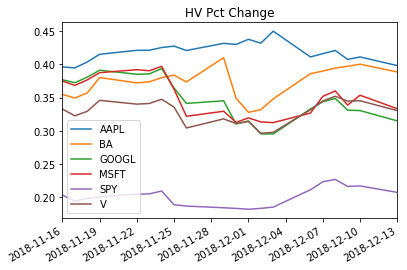

In [14]:
hv_1_df_ = hv_1(historicals, portfolio)
hv_1_df_.plot(title = 'HV Pct Change')

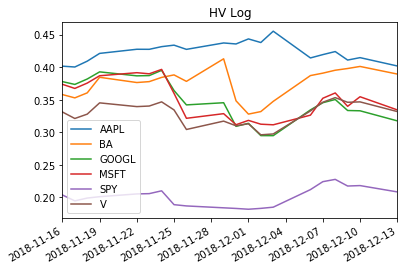

In [16]:
hv_2_df_ = hv_2(historicals, portfolio)
hv_2_df_.plot(title = 'HV Log')

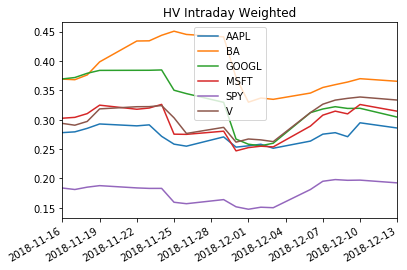

In [17]:
hv_weighted_df_ = hv_weighted(historicals, portfolio, 1)
hv_weighted_df_.plot(title = 'HV Intraday Weighted')

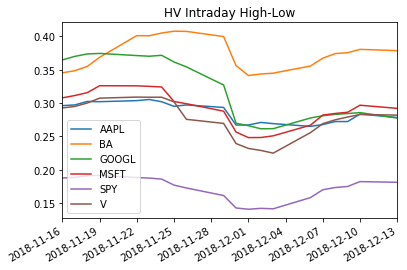

In [18]:
hv_hl_df_ = hv_hl(historicals, portfolio)
hv_hl_df_.plot(title = 'HV Intraday High-Low')

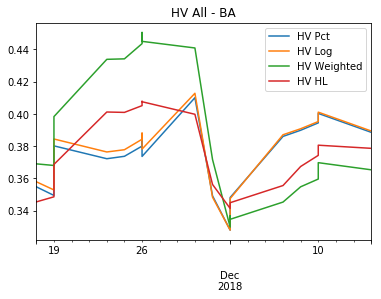

In [19]:
hv_all_ = hv_all('BA', hv_1_df_, hv_2_df_, hv_weighted_df_, hv_hl_df_)
hv_all_.plot(title = 'HV All - BA')

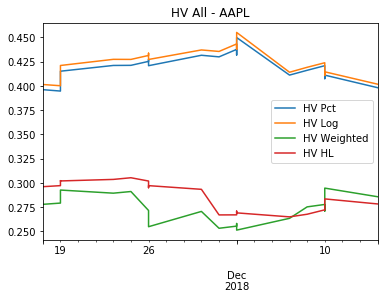

In [20]:
hv_all_ = hv_all('AAPL', hv_1_df_, hv_2_df_, hv_weighted_df_, hv_hl_df_)
hv_all_.plot(title = 'HV All - AAPL')

In [21]:
def graph_option_1(chain, stock):
    chain_ = chain.loc[chain['Stock'] == stock]
    fig = plt.figure()
    ax = Axes3D(fig)
    Axes3D.mouse_init(ax)
    surf = ax.plot_trisurf(chain_["Strike"], chain_["T"], chain_["Call Premium"], cmap=cm.RdBu, linewidth=0.5, antialiased=False)
    ax.set_title('3-D Options Surface for '+ stock)
    # fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


def graph_option_subplot(chain, chain_2, stock, stock_2 = None): 
    if (stock_2 == None): 
        stock_2 = stock
    chain_ = chain.loc[chain['Stock'] == stock]
    chain_2 = chain.loc[chain['Stock'] == stock_2]
    
    x = chain_["Strike"]
    y = chain_["T"]
    tri = mtri.Triangulation(x, y)
    
    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_trisurf(x,y, chain_["Call Premium"], triangles=tri.triangles, cmap=plt.cm.CMRmap,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)
    
    x1 = chain_2["Strike"]
    y1 = chain_2["T"]
    tri = mtri.Triangulation(x1, y1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_trisurf(x1, y1, chain_2["Spread"], triangles=tri.triangles, cmap=plt.cm.Spectral,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)

    plt.show()
    
def graph_real_option_subplot(chain, stock): 
    chain_ = chain.loc[((chain['underlying'] == stock) & (chain['option_type'] == 'call'))]
    chain_2 = chain.loc[((chain['underlying'] == stock) & (chain['option_type'] == 'put'))]
    
    x = chain_["strike"]
    y = chain_["T"]
    tri = mtri.Triangulation(x, y)
    
    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_trisurf(x,y, chain_["Spread"], triangles=tri.triangles, cmap=plt.cm.CMRmap,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)
    
    x1 = chain_2["strike"]
    y1 = chain_2["T"]
    tri = mtri.Triangulation(x1, y1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_trisurf(x1, y1, chain_2["Spread"], triangles=tri.triangles, cmap=plt.cm.Spectral,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)

    plt.show()

### Each quarter, on the third Friday in March, June, September, and January*

In [27]:
t_exp = {}
for stock in portfolio:    
    t_exp[stock] = t_(date.today(), options_dates)

In [28]:
for stock in portfolio: 
    for i in range(len(t_exp[stock])): 
        while(not tradier.check_expiration(t_exp[stock][i], stock)): 
            print(stock, t_exp[stock][i])
            t_ = input()
            t_ = t_.split(',')
            t_ = date(int(t_[0]), int(t_[1]), int(t_[2]))
            t_exp[stock][i] = t_

BA 2019-03-15
2019,02,15
BA 2020-06-19
2021,01,15
V 2020-06-19
2021,01,15


In [30]:
r = list((fred.get_series('DGS1', sort_order = 'desc', limit = 1).to_dict()).values())[0]/100
q_matrix = extractQ(p, stocks)
strikes = strikes_(p, 5)
default = list((fred.get_series('BAMLH0A0HYM2', sort_order = 'desc', limit = 1).to_dict()).values())[0]/100
stats = stocks.get_key_stats()
beta = {}
for stock in portfolio:
    beta[stock] = stats[stock]['beta']

In [31]:
c t = pd.DataFrame(columns = ["Stock", "Underlying Price", "Call Premium", "Put Premium", "Strike", "Expiry", "T"])
i = 0
sigma_matrix = hv_weighted_df_.iloc[len(hv_weighted_df_.index)-1].to_dict()
for stock in strikes: 
    for t_d in t_exp[stock]:
        for x in strikes[stock]:
            sigma = sigma_matrix[stock]
            q = q_matrix[stock]
            t = ((t_d-date.today()).days)/365 
            s = p[stock]
            d1 = d1_(s, x, t, r, q, sigma)
            d2 = d2_(d1, sigma, t)
            obj = {
                    "Stock": stock,
                    "Underlying Price": s, 
                    "Call Premium": round(call_(s, x, t, r, q, d1, d2), 4),
                    "Put Premium": round(put_(s, x, t, r, q, d1, d2), 4),
                    "Strike": x,
                    "Expiry": t_d, 
                    "T": t
                }
            temp = pd.DataFrame(obj, index = [i])
            chains_blackscholes = pd.concat([chains_blackscholes, temp], ignore_index = True)  
            i+=1       

In [33]:
chains_extension = pd.DataFrame(columns = ["Stock", "Underlying Price", "Call Premium", "Put Premium", "Strike", "Expiry", "T"])
i = 0
sigma_matrix = hv_weighted_df_.iloc[len(hv_weighted_df_.index)-1].to_dict()
for stock in strikes: 
    for t_d in t_exp[stock]:
        for x in strikes[stock]:
            sigma = sigma_matrix[stock]
            q = q_matrix[stock]
            t = ((t_d-date.today()).days)/365 
            s = p[stock]
            d1 = d1_(s, x, t, r, q, sigma)
            d2 = d2_(d1, sigma, t)
            obj = {
                    "Stock": stock,
                    "Underlying Price": s, 
                    "Call Premium": round(call_(s, x, t, r, q, d1, d2) * M_(1, default, beta[stock], t), 4),
                    "Put Premium": round(put_(s, x, t, r, q, d1, d2) * (1/M_(1, default, beta[stock], t)), 4),
                    "Strike": x,
                    "Expiry": t_d, 
                    "T": t
                }
            temp = pd.DataFrame(obj, index = [i])
            chains_extension = pd.concat([chains_extension, temp], ignore_index = True)  
            i+=1  

In [34]:
chain_realtime = pd.DataFrame(columns = ['ask','bid', 'strike', 'underlying', 'volume', 'expiration_date', 'option_type'])
for stock in portfolio: 
    for t in t_exp[stock]: 
        temp = tradier.get_option_chain(stock, t, "pandas")
        temp = temp[temp['strike'].isin(strikes[stock])]
        temp = temp[['ask','bid', 'strike', 'underlying', 'volume', 'expiration_date', 'option_type']]
        chain_realtime = pd.concat([chain_realtime,temp])

In [35]:
chains_blackscholes

,Call Premium,Expiry,Put Premium,Stock,Strike,T,Underlying Price
0,21.1279,2019-01-18,0.0342,MSFT,85.0,0.095890,106.03
1,16.2774,2019-01-18,0.1708,MSFT,90.0,0.095890,106.03
2,11.7261,2019-01-18,0.6066,MSFT,95.0,0.095890,106.03
3,7.7650,2019-01-18,1.6326,MSFT,100.0,0.095890,106.03
4,4.6624,2019-01-18,3.5172,MSFT,105.0,0.095890,106.03
5,2.5175,2019-01-18,6.3593,MSFT,110.0,0.095890,106.03
6,1.2188,2019-01-18,10.0478,MSFT,115.0,0.095890,106.03
7,0.5298,2019-01-18,14.3459,MSFT,120.0,0.095890,106.03
8,0.2077,2019-01-18,19.0109,MSFT,125.0,0.095890,106.03
9,0.0739,2019-01-18,23.8642,MSFT,130.0,0.095890,106.03


In [36]:
chains_extension

,Call Premium,Expiry,Put Premium,Stock,Strike,T,Underlying Price
0,40.1219,2019-01-18,0.0180,MSFT,85.0,0.095890,106.03
1,30.9107,2019-01-18,0.0899,MSFT,90.0,0.095890,106.03
2,22.2679,2019-01-18,0.3194,MSFT,95.0,0.095890,106.03
3,14.7457,2019-01-18,0.8597,MSFT,100.0,0.095890,106.03
4,8.8540,2019-01-18,1.8521,MSFT,105.0,0.095890,106.03
5,4.7807,2019-01-18,3.3488,MSFT,110.0,0.095890,106.03
6,2.3145,2019-01-18,5.2911,MSFT,115.0,0.095890,106.03
7,1.0061,2019-01-18,7.5545,MSFT,120.0,0.095890,106.03
8,0.3944,2019-01-18,10.0110,MSFT,125.0,0.095890,106.03
9,0.1403,2019-01-18,12.5667,MSFT,130.0,0.095890,106.03


In [57]:
chain_realtime['spread'] = (chain_realtime['bid'] + chain_realtime['ask'])/2
chain_realtime['T']  = chain_realtime.loc[:,'expiration_date'].apply(lambda x: x.split('-')) 
chain_realtime['T']  = chain_realtime.loc[:,'T'].apply(lambda x: ((date(int(x[0]),int(x[1]),int(x[2]))-date.today()).days)/365) 

In [58]:
chain_realtime

,ask,bid,strike,underlying,volume,expiration_date,option_type,spread,T
44,0.27,0.18,85.0,MSFT,35,2019-01-18,put,0.225,0.095890
45,21.65,21.35,85.0,MSFT,12,2019-01-18,call,21.500,0.095890
48,0.48,0.40,90.0,MSFT,242,2019-01-18,put,0.440,0.095890
49,16.85,16.55,90.0,MSFT,146,2019-01-18,call,16.700,0.095890
52,12.35,12.05,95.0,MSFT,58,2019-01-18,call,12.200,0.095890
53,0.90,0.82,95.0,MSFT,1538,2019-01-18,put,0.860,0.095890
56,1.75,1.63,100.0,MSFT,3128,2019-01-18,put,1.690,0.095890
57,8.15,7.90,100.0,MSFT,184,2019-01-18,call,8.025,0.095890
58,3.35,3.15,105.0,MSFT,12306,2019-01-18,put,3.250,0.095890
59,4.70,4.50,105.0,MSFT,8174,2019-01-18,call,4.600,0.095890


KeyError: 'Spread'

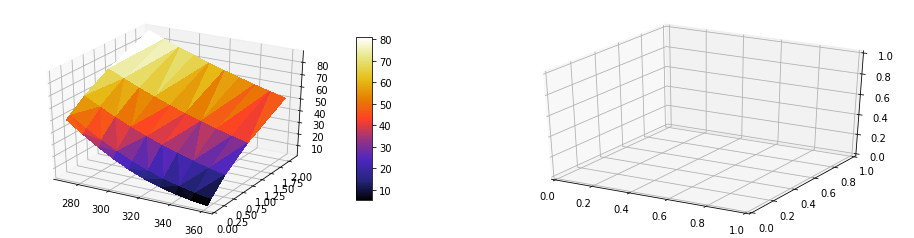

In [38]:
graph_option_subplot(chains_blackscholes, chains_extension, portfolio[1])

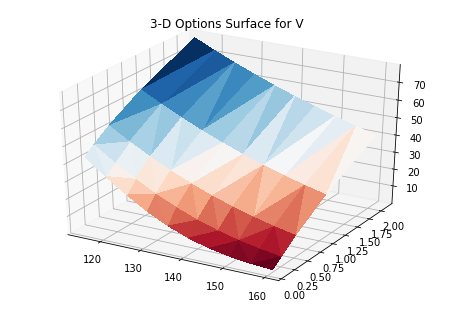

In [254]:
graph_option_1(chains_extension, portfolio[3])

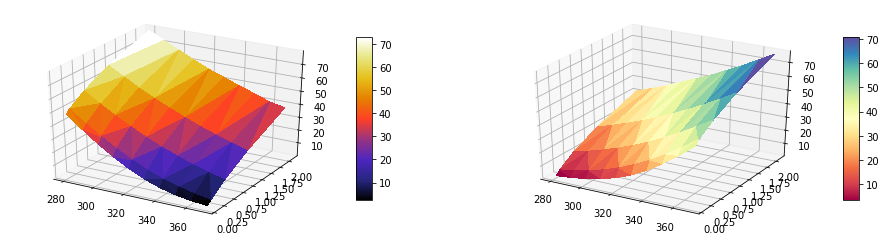

In [287]:
graph_real_option_subplot(chain_realtime, portfolio[1])

In [73]:
stock = 'BA'
temp = chain_realtime[((chain_realtime['underlying'] == stock) & (chain_realtime['option_type'] == 'call'))]
x1 = np.linspace(temp['strike'].min(), temp['strike'].max(), len(temp['strike'].unique()))
y1 = np.linspace(temp['T'].min(), temp['T'].max(), len(temp['T'].unique()))
z1 = np.linspace(temp['spread'].min(), temp['spread'].max(), len(temp['spread'].unique()))
x2, y2 = np.meshgrid(x1, y1)
z2 = griddata((temp['strike'], temp['T']), temp['spread'], (x2, y2), method='cubic')
# fig = plt.figure()

print(y1)
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm,
#     linewidth=0, antialiased=False)

# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.title('Meshgrid Created from 3 1D Arrays')
# plt.show()

[ 0.09589041  0.59452055  1.09315068  1.59178082  2.09041096]


In [75]:
stock = 'BA'
temp = chain_realtime[((chain_realtime['underlying'] == stock) & (chain_realtime['option_type'] == 'call'))]
x = temp['strike']
y = temp['T']
z = temp['spread']
points2D = np.vstack([x,y]).T
tri = Delaunay(points2D)
simplices = tri.simplices

fig1 = FF.create_trisurf(x=x, y=y, z=z,
                         simplices=simplices,
                         title="Torus", aspectratio=dict(x=1, y=1, z=0.3))
py.iplot(fig1, filename="BAVolatilityCurve")

In [92]:
stock = 'AAPL'
temp = chain_realtime[((chain_realtime['underlying'] == stock) & (chain_realtime['option_type'] == 'call'))]
temp2 = chains_blackscholes[(chains_blackscholes['Stock'] == stock)]
temp3 = chains_extension[(chains_extension['Stock'] == stock)]
x = temp['strike']
y = temp['T']
z = temp['spread']
x1 = temp2['Strike']
y1 = temp2['T']
z1 = temp2['Call Premium']
x2 = temp3['Strike']
y2 = temp3['T']
z2 = temp3['Call Premium']

points2D = np.vstack([x,y]).T
tri = Delaunay(points2D)
simplices = tri.simplices

points2D1 = np.vstack([x1,y1]).T
tri1 = Delaunay(points2D1)
simplices1 = tri1.simplices

points2D2 = np.vstack([x2,y2]).T
tri2 = Delaunay(points2D2)
simplices2 = tri2.simplices

fig = FF.create_trisurf(x=x, y=y, z=z,colormap=['rgb(255, 155, 120)', 'rgb(255, 153, 255)', ],
                         simplices=simplices,
                         title="Torus", plot_edges=False, aspectratio=dict(x=1, y=1, z=0.3))
fig2 = FF.create_trisurf(x=x1, y=y1, z=z1,colormap=['rgb(0, 155, 150)', 'rgb(105, 153, 255)', ],
                         simplices=simplices1,
                         title="Torus", plot_edges=False, aspectratio=dict(x=1, y=1, z=0.3))
fig3 = FF.create_trisurf(x=x2, y=y2, z=z2,colormap=['rgb(50, 50, 50)', 'rgb(0, 0, 0)', ],
                         simplices=simplices2,
                         title="Torus", plot_edges=False, aspectratio=dict(x=1, y=1, z=0.3))

data = [fig.data[0], fig.data[1], fig2.data[0], fig2.data[1], fig3.data[0], fig3.data[1]]
# data = [fig3.data[0], fig3.data[1]]

py.iplot(data, filename="AAPLCALLVolatilityCurve")

In [62]:
surface = go.Surface(x1, y1, z2)
data = [surface]

layout = go.Layout(
    title='Parametric Plot',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Realtime options call data on MSFT')

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 40))



ValueError: The first argument to the plotly.graph_objs.Surface 
constructor must be a dict or 
an instance of plotly.graph_objs.Surface